## Recommendation Model

In [220]:
import sys
sys.path.append('../')
from src.utils.imports import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
import warnings
warnings.filterwarnings('ignore')

In [221]:
print("Loading data...")
df = pd.read_csv('data/processed/customers_cleaned.csv')
print("Shape:", df.shape)


Loading data...
Shape: (2023070, 18)


In [222]:
print("\nFiltering data...")
user_counts = df['userId'].value_counts()
item_counts = df['productId'].value_counts()

valid_users = user_counts[user_counts >= 5].index
valid_items = item_counts[item_counts >= 5].index

df_filtered = df[
    df['userId'].isin(valid_users) & 
    df['productId'].isin(valid_items)
]


Filtering data...


In [223]:
global_mean = df['rating'].mean()

In [224]:
max_users = 10000
max_items = 10000

valid_users = valid_users[:max_users]
valid_items = valid_items[:max_items]

df_filtered = df_filtered[
    df_filtered['userId'].isin(valid_users) & 
    df_filtered['productId'].isin(valid_items)
]

In [225]:
user_mapper = {id: idx for idx, id in enumerate(valid_users)}
item_mapper = {id: idx for idx, id in enumerate(valid_items)}

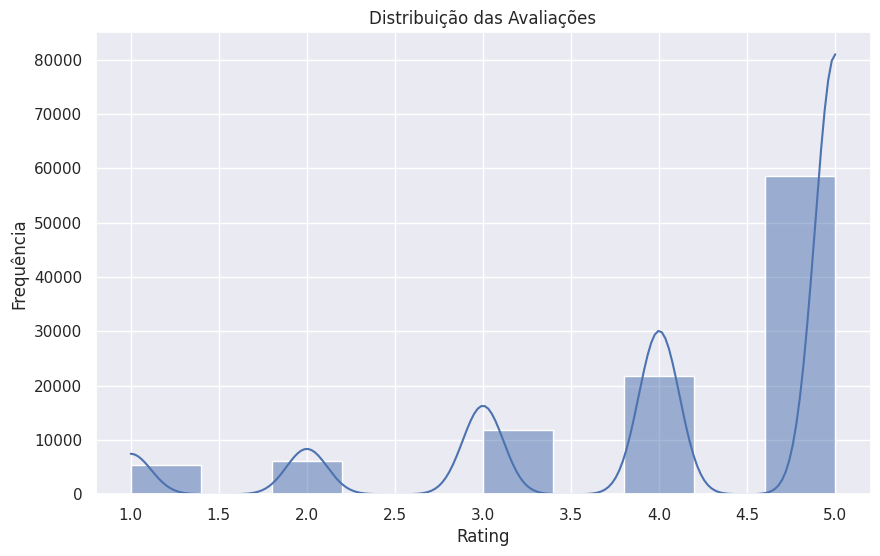

In [226]:
plt.figure(figsize=(10, 6))
sns.histplot(df_filtered['rating'], bins=10, kde=True)
plt.title("Distribuição das Avaliações")
plt.xlabel("Rating")
plt.ylabel("Frequência")
plt.show()

In [227]:
df_normalized = df_filtered.copy()
df_normalized['rating'] = df_filtered['rating'] - global_mean

In [228]:
print("\nCreating sparse matrix...")
row = df_normalized['userId'].map(user_mapper)
col = df_normalized['productId'].map(item_mapper)
data = df_normalized['rating']

ratings_matrix = csr_matrix(
    (data, (row, col)), 
    shape=(len(user_mapper), len(item_mapper))
)


Creating sparse matrix...


In [229]:
print("\nTraining model...")
n_factors = 20
U, sigma, Vt = svds(ratings_matrix, k=n_factors)


Training model...


In [230]:
def get_recommendations(user_id, n_recommendations=5):
    if user_id not in user_mapper:
        return []
    
    user_idx = user_mapper[user_id]
    sigma_diag = np.diag(sigma)
    
    user_pred = np.dot(np.dot(U[user_idx:user_idx+1], sigma_diag), Vt).flatten()
    user_pred = user_pred + global_mean
    
    user_ratings = ratings_matrix[user_idx].toarray().flatten()
    unrated_items = np.where(user_ratings == 0)[0]
    
    pred_ratings = user_pred[unrated_items]
    pred_ratings = np.clip(pred_ratings, 1, 5)
    
    top_indices = (-pred_ratings).argsort()[:n_recommendations]
    top_items = unrated_items[top_indices]
    top_ratings = pred_ratings[top_indices]
    
    reverse_item_mapper = {v: k for k, v in item_mapper.items()}
    return [(reverse_item_mapper[idx], rating) for idx, rating in zip(top_items, top_ratings)]

In [231]:
def evaluate_model(U, sigma, Vt, global_mean, batch_size=1000):
    n_users = U.shape[0]
    sigma_diag = np.diag(sigma)
    total_se = 0
    total_ae = 0
    total_samples = 0
    
    for start_idx in range(0, n_users, batch_size):
        end_idx = min(start_idx + batch_size, n_users)
        
        U_batch = U[start_idx:end_idx]
        pred_batch = np.dot(np.dot(U_batch, sigma_diag), Vt)
        pred_batch = pred_batch + global_mean
        pred_batch = np.clip(pred_batch, 1, 5)
        
        true_batch = ratings_matrix[start_idx:end_idx].toarray()
        mask = true_batch != 0
        
        if mask.sum() > 0:
            true_ratings = true_batch[mask]
            pred_ratings = pred_batch[mask]
            
            valid_mask = ~np.isnan(true_ratings) & ~np.isnan(pred_ratings)
            if valid_mask.sum() > 0:
                total_se += np.sum((true_ratings[valid_mask] - pred_ratings[valid_mask]) ** 2)
                total_ae += np.sum(np.abs(true_ratings[valid_mask] - pred_ratings[valid_mask]))
                total_samples += valid_mask.sum()
    
    if total_samples > 0:
        rmse = np.sqrt(total_se / total_samples)
        mae = total_ae / total_samples
    else:
        rmse = mae = float('inf')
    
    return rmse, mae

In [232]:
print("\nEvaluating model...")
rmse, mae = evaluate_model(U, sigma, Vt, global_mean)
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")


Evaluating model...


RMSE: 4.2657
MAE: 4.1169


In [233]:
if len(valid_users) > 0:
    test_user = valid_users[0]
    print(f"\nRecommendations for user {test_user}:")
    recs = get_recommendations(test_user)
    for prod_id, pred_rating in recs:
        print(f"Product {prod_id}: Predicted Rating = {pred_rating:.2f}")



Recommendations for user 821601:
Product 36929: Predicted Rating = 4.99
Product 35016: Predicted Rating = 4.32
Product 105018: Predicted Rating = 4.30
Product 243416: Predicted Rating = 4.29
Product 238626: Predicted Rating = 4.29


In [234]:
print("\nStatistics:")
print(f"Number of users: {len(user_mapper)}")
print(f"Number of products: {len(item_mapper)}")
print(f"Number of ratings: {ratings_matrix.nnz}")
print(f"Sparsity: {(1 - ratings_matrix.nnz/(len(user_mapper)*len(item_mapper)))*100:.2f}%")



Statistics:
Number of users: 10000
Number of products: 10000
Number of ratings: 103478
Sparsity: 99.90%


In [235]:
print("\nSaving model...")
try:
    os.makedirs('models', exist_ok=True)
    np.savez('models/recommendation_model.npz', 
             U=U, sigma=sigma, Vt=Vt,
             user_mapper=np.array(list(user_mapper.items())),
             item_mapper=np.array(list(item_mapper.items())),
             ratings_mean=global_mean)
    print("Model saved successfully")
except Exception as e:
    print(f"Error saving model: {str(e)}")


Saving model...
Model saved successfully
